In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split
from PIL import Image
from blitz.modules import BayesianLinear, BayesianConv2d
from blitz.losses import kl_divergence_from_nn

In [4]:
# Dataset Configuration
data_dir = r"C:\Users\User\Downloads\archive\Dataset_BUSI_with_GT"  # Sesuaikan path dataset Anda
image_size = (224, 224)
batch_size = 32
num_classes = 3
num_epochs = 25
kl_weight = 0.001

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Data Augmentation & Normalization
train_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

val_transform = transforms.Compose([
    transforms.Resize(image_size),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Custom Dataset Class
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, samples, transform=None):
        self.samples = samples
        self.transform = transform

    def __getitem__(self, index):
        path, target = self.samples[index]
        img = Image.open(path).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img, target

    def __len__(self):
        return len(self.samples)

# Load Dataset & Split
full_dataset = datasets.ImageFolder(root=data_dir)
train_samples, val_samples = train_test_split(
    full_dataset.samples, test_size=0.2, stratify=full_dataset.targets, random_state=42
)

train_dataset = CustomDataset(train_samples, transform=train_transform)
val_dataset = CustomDataset(val_samples, transform=val_transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Dynamic Feature Map Calculation
def get_feature_map_size(model, input_size=(3, 224, 224)):
    with torch.no_grad():
        dummy_input = torch.randn(1, *input_size)
        dummy_output = model.features(dummy_input)
        return dummy_output.shape[1:]  # (C, H, W)


In [5]:
print(f'Number of training samples: {len(train_dataset)}')
print(f'Number of validation samples: {len(val_dataset)}')

Number of training samples: 1262
Number of validation samples: 316


In [6]:
# Bayesian AlexNet
class BayesianAlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 96, kernel_size=11, stride=4, padding=2), nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(96, 256, kernel_size=5, padding=2), nn.ReLU(),
            nn.LocalResponseNorm(size=5, alpha=0.0001, beta=0.75, k=2),
            nn.MaxPool2d(kernel_size=3, stride=2),

            nn.Conv2d(256, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 384, kernel_size=3, padding=1), nn.ReLU(),
            nn.Conv2d(384, 256, kernel_size=3, padding=1), nn.ReLU(),
            nn.MaxPool2d(kernel_size=3, stride=2),
        )
        feature_map_size = get_feature_map_size(self)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            BayesianLinear(feature_map_size[0] * feature_map_size[1] * feature_map_size[2], 4096), nn.ReLU(),
            nn.Dropout(0.5), BayesianLinear(4096, 4096), nn.ReLU(),
            nn.Dropout(0.5), BayesianLinear(4096, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

# Standard AlexNet (Non-Bayesian)
class StandardAlexNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.features = BayesianAlexNet().features  # Sama dengan model Bayesian
        feature_map_size = get_feature_map_size(self)
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(feature_map_size[0] * feature_map_size[1] * feature_map_size[2], 4096), nn.ReLU(),
            nn.Linear(4096, 4096), nn.ReLU(),
            nn.Linear(4096, num_classes)
        )
    def forward(self, x):
        x = self.features(x)
        return self.classifier(x)

In [7]:
# Initialize Models
bayesian_model = BayesianAlexNet().to(device)
standard_model = StandardAlexNet().to(device)

# Loss & Optimizer
criterion = nn.CrossEntropyLoss()
optimizer_bayesian = optim.Adam(bayesian_model.parameters(), lr=0.001)
optimizer_standard = optim.Adam(standard_model.parameters(), lr=0.001)


In [8]:
# Training & Evaluation Functions

def train_model(model, optimizer, is_bayesian=False):
    model.train()
    running_loss, correct, total = 0.0, 0, 0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        if is_bayesian:
            loss += kl_weight * kl_divergence_from_nn(model)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        correct += outputs.argmax(dim=1).eq(labels).sum().item()
        total += labels.size(0)
    return running_loss/len(train_loader), 100. * correct / total

# Training Loop
for epoch in range(num_epochs):
    train_loss_b, train_acc_b = train_model(bayesian_model, optimizer_bayesian, True)
    train_loss_s, train_acc_s = train_model(standard_model, optimizer_standard, False)
    print(f"Epoch {epoch+1}: Bayesian Acc: {train_acc_b:.2f}%, Standard Acc: {train_acc_s:.2f}%")


Epoch 1: Bayesian Acc: 41.68%, Standard Acc: 50.08%
Epoch 2: Bayesian Acc: 49.21%, Standard Acc: 60.86%
Epoch 3: Bayesian Acc: 51.19%, Standard Acc: 58.95%
Epoch 4: Bayesian Acc: 55.47%, Standard Acc: 66.16%
Epoch 5: Bayesian Acc: 54.99%, Standard Acc: 64.03%
Epoch 6: Bayesian Acc: 58.87%, Standard Acc: 66.09%
Epoch 7: Bayesian Acc: 60.22%, Standard Acc: 67.04%
Epoch 8: Bayesian Acc: 61.65%, Standard Acc: 66.72%
Epoch 9: Bayesian Acc: 64.10%, Standard Acc: 65.61%
Epoch 10: Bayesian Acc: 62.68%, Standard Acc: 65.45%
Epoch 11: Bayesian Acc: 64.82%, Standard Acc: 69.57%
Epoch 12: Bayesian Acc: 64.50%, Standard Acc: 70.52%
Epoch 13: Bayesian Acc: 65.37%, Standard Acc: 69.81%
Epoch 14: Bayesian Acc: 66.16%, Standard Acc: 71.79%
Epoch 15: Bayesian Acc: 66.80%, Standard Acc: 71.63%
Epoch 16: Bayesian Acc: 66.48%, Standard Acc: 73.45%
Epoch 17: Bayesian Acc: 68.23%, Standard Acc: 74.25%
Epoch 18: Bayesian Acc: 66.72%, Standard Acc: 75.04%
Epoch 19: Bayesian Acc: 66.88%, Standard Acc: 75.28%
Ep

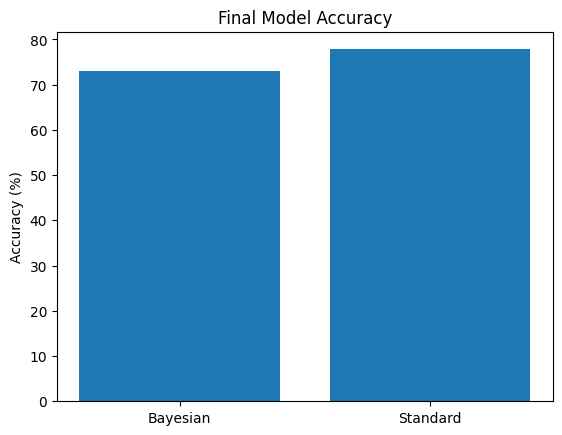

In [9]:
# Visualisasi Hasil Akhir
def plot_results(bayesian_acc, standard_acc):
    plt.bar(['Bayesian', 'Standard'], [bayesian_acc, standard_acc])
    plt.ylabel("Accuracy (%)")
    plt.title("Final Model Accuracy")
    plt.show()

plot_results(train_acc_b, train_acc_s)
